In [1]:
"""
Extract betas for from full model interaction results
Author: Taylor Salo and Jessica Bartley
Last Edited: 9/25/19
"""
import os
from os.path import basename, join
from glob import glob

import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.masking import apply_mask

from nilearn import input_data, plotting, surface, datasets
import nilearn as ni
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=3)
sns.set_style("white")

# paths
basedir = '/home/data/nbc/physics-learning/data/second-level/'
repodir = '/home/data/nbc/physics-learning/paper-3/physics-learning-prepost/'
maskdir = '/home/data/nbc/physics-learning/paper-3/physics-learning-prepost/fullmodel_interaction_rois'
behavioral_basedir = '/home/data/nbc/physics-learning/data/behavioral-data/analyses/physics-learning-behavioral'
behavioral_datadir = 'datafiles'
behavioral_plotdir = 'plots'

/home/data/nbc/nbclab-env/env-py2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# get paths for retr nii
subjects = glob(join(basedir, '*'))
subjects = [basename(s) for s in subjects]
subjects = sorted([s for s in subjects if s.isdigit() and len(s)==3])
sessions = ['session-0', 'session-1']
conditions = ['retr']#, 'fci']
temp_path_files = ['retr_paths.txt', 'fci_paths.txt']
for temp_f in temp_path_files:
    if os.path.exists(temp_f):
        os.remove(temp_f)
retr_paths = open("retr_paths.txt", "w")
#fci_paths = open("fci_paths.txt", "w")
for s in subjects:
    for ss in sessions:
        for condition in conditions:
            if condition == 'retr':
                files = sorted(glob(join(basedir, 
                                         s, ss, condition, 
                                         '{0}-{1}-{2}-5mm.gfeat'.format(s, ss, condition), 
                                         'cope2.feat/stats/cope1.nii.gz')))
                if len(files) == 1:
                    retr_paths.write("{0}\n".format(str(files)[2:-2]))
#            elif condition == 'fci':
#                files = sorted(glob(join(basedir, 
#                                         s, ss, condition, 
#                                         '{0}-{1}-{2}-5mm.gfeat'.format(s, ss, condition), 
#                                         'cope3.feat/stats/cope1.nii.gz')))
#                if len(files) == 1:
#                    fci_paths.write("{0}\n".format(str(files)[2:-2]))
            else:
                print 'something went wrong'
retr_paths.close()
#fci_paths.close()

In [3]:
condition_files = ['retr_paths.txt']#, 'fci_paths.txt']

#retr_mask_files = ['retr_fullmodel_phys-gen_neggenderXtimeClust1.nii.gz', 
#                   'retr_fullmodel_phys-gen_neggenderXtimeClust2.nii.gz', 
#                   'retr_fullmodel_phys-gen_neggenderXtimeClust3.nii.gz', 
#                   'retr_fullmodel_phys-gen_neggenderXtimeClust4.nii.gz', 
#                   'retr_fullmodel_phys-gen_classXgenderXtimeClust1.nii.gz', 
#                   'retr_fullmodel_phys-gen_classXgenderXtimeClust2.nii.gz', 
#                   'retr_fullmodel_phys-gen_classXgenderXtimeClust3.nii.gz']

retr_mask_files = ['retr_fullmodel_phys-gen_neggenderXtimeClust1_masked.nii.gz', 
                   'retr_fullmodel_phys-gen_neggenderXtimeClust2_masked.nii.gz', 
                   'retr_fullmodel_phys-gen_neggenderXtimeClust3_masked.nii.gz', 
                   'retr_fullmodel_phys-gen_neggenderXtimeClust4_masked.nii.gz', 
                   'retr_fullmodel_phys-gen_classXgenderXtimeClust1_masked.nii.gz', 
                   'retr_fullmodel_phys-gen_classXgenderXtimeClust2_masked.nii.gz', 
                   'retr_fullmodel_phys-gen_classXgenderXtimeClust3_masked.nii.gz']

In [4]:
# extract betas to pandas df
# note images are already in mni space because they are from second-level analyses
dfs = []
for condition_file in condition_files:
    condition_name = condition_file.split('_')[0]

    in_df = pd.read_csv(condition_file, header=None)
    mni_cope_files = in_df[0].tolist()
    subjects = [ci.split('/')[7] for ci in mni_cope_files]
    sessions = [ci.split('/')[8] for ci in mni_cope_files]
    
    data_imgs = []
    for i_sub, data_file in enumerate(mni_cope_files):
        data_img = nib.load(data_file)
        data_imgs.append(data_img)

    temp_dfs = []
    for j_mask, mask_file in enumerate(retr_mask_files):
        mask = join(maskdir, mask_file)
        mask_name = mask_file.split('_')[3]
        mask_img = nib.load(mask)
        mask_betas = apply_mask(imgs=data_imgs, mask_img=mask_img)
        mask_betas = mask_betas.mean(axis=1)

        df = pd.DataFrame(index=subjects, columns=[mask_name],
                          data=mask_betas.T)
        temp_dfs.append(df)
    temp_df = pd.concat(temp_dfs, axis=1)
    temp_df['Condition'] = condition_name
    temp_df['Session'] = sessions
    dfs.append(temp_df)
df2 = pd.concat(dfs, axis=0)

# clean up col names
#df2 = df2.rename(columns={'neggenderXtimeClust1.nii.gz': 'Neg Gender X Time Clust 1', 
#                             'neggenderXtimeClust2.nii.gz': 'Neg Gender X Time Clust 2', 
#                             'neggenderXtimeClust3.nii.gz': 'Neg Gender X Time Clust 3', 
#                             'neggenderXtimeClust4.nii.gz': 'Neg Gender X Time Clust 4', 
#                             'classXgenderXtimeClust1.nii.gz': 'Class X Gender X Time Clust 1', 
#                             'classXgenderXtimeClust2.nii.gz': 'Class X Gender X Time Clust 2', 
#                             'classXgenderXtimeClust3.nii.gz': 'Class X Gender X Time Clust 3'})

df2 = df2.rename(columns={'neggenderXtimeClust1': 'Neg Gender X Time Clust 1', 
                             'neggenderXtimeClust2': 'Neg Gender X Time Clust 2', 
                             'neggenderXtimeClust3': 'Neg Gender X Time Clust 3', 
                             'neggenderXtimeClust4': 'Neg Gender X Time Clust 4', 
                             'classXgenderXtimeClust1': 'Class X Gender X Time Clust 1', 
                             'classXgenderXtimeClust2': 'Class X Gender X Time Clust 2', 
                             'classXgenderXtimeClust3': 'Class X Gender X Time Clust 3'})

df2['Subject'] = df2.index
df2['Subject'] = df2['Subject'].astype(int)
df2['Session'] = df2['Session'].map({'session-0': 'pre', 'session-1': 'post'})

# drop unmatched data
unmatched = []
for subid in df2['Subject'].unique():    
    row = df2.loc[df2['Subject'] == subid, 'Condition'].index
    if len(row) == 1:
        unmatched.append(row)
for i in unmatched:
    df2.drop(i, inplace = True)

# make into pre and post dfs
df2_pre = df2.loc[df2['Session']=='pre']
df2_post = df2.loc[df2['Session']=='post']

df2.to_csv(join(repodir, 'retr_betas.csv'))
df2_post.head()

,Neg Gender X Time Clust 1,Neg Gender X Time Clust 2,Neg Gender X Time Clust 3,Neg Gender X Time Clust 4,Class X Gender X Time Clust 1,Class X Gender X Time Clust 2,Class X Gender X Time Clust 3,Condition,Session,Subject
101,-4.554911,2.071083,9.335915,-3.134180,-9.657184,-8.042769,-49.701160,retr,post,101
102,-13.583057,-9.215669,-1.767312,-12.080291,9.970931,-19.518579,-54.006264,retr,post,102
103,5.671247,3.682387,4.551041,4.615973,18.157503,10.710962,1.971609,retr,post,103
104,-3.998456,-5.362240,-5.239585,2.672390,21.620592,-2.437270,-16.524681,retr,post,104
106,-10.456861,-4.473469,-15.134920,-7.662620,16.695480,0.624856,-38.164848,retr,post,106


In [5]:
# separate df's into pre and post instruction and add columns for gender and class
f_gen_class = os.path.join(behavioral_basedir, behavioral_datadir, 'c123456-demographics.txt')

df_gen_class = pd.read_csv(f_gen_class, sep='\t')
df_gen_class['Group'] = df_gen_class['Group'].map({'Trad': 'Lecture', 'Mod': 'Modeling'})
df_gen_class = df_gen_class.rename(columns={'PID': 'Subject', 'Group': 'Class'})
df_gen_class = df_gen_class.loc[df_gen_class['Cmp.Stdy']=='Y']#drop unmatched
df_gen_class = df_gen_class.drop(['Cmp.Stdy'], axis=1)
df_gen_class['Gender And Class'] = df_gen_class['Class'] + ' ' + df_gen_class['Gender']

# merge df's
df_pre = pd.merge(df2_pre, df_gen_class, on='Subject')
df_post = pd.merge(df2_post, df_gen_class, on='Subject')
dfs = [df_pre, df_post]
df_full = pd.concat(dfs)

df_full.to_csv(join(repodir, 'retr_betas_wsex.csv'))
df_full.head()

,Neg Gender X Time Clust 1,Neg Gender X Time Clust 2,Neg Gender X Time Clust 3,Neg Gender X Time Clust 4,Class X Gender X Time Clust 1,Class X Gender X Time Clust 2,Class X Gender X Time Clust 3,Condition,Session,Subject,Gender,Class,Gender And Class
0,1.485103,2.415100,-7.582503,-2.031364,13.659383,16.340864,-16.803932,retr,pre,101,F,Lecture,Lecture F
1,23.554415,8.008616,4.696402,18.169527,47.109665,26.150620,32.594128,retr,pre,102,M,Modeling,Modeling M
2,3.580490,-0.575656,2.319325,-0.133577,9.804849,-0.160376,-25.867615,retr,pre,103,M,Lecture,Lecture M
3,-3.394952,-5.677502,0.049634,-1.897698,-2.996679,-11.354383,-7.329817,retr,pre,104,F,Modeling,Modeling F
4,-1.468038,-3.269103,-4.067667,0.713320,19.059200,11.465408,-38.078934,retr,pre,106,M,Modeling,Modeling M


In [6]:
# make separate dfs for plotting

twoway_clust1_df = df_full[['Subject', 'Session', 'Neg Gender X Time Clust 1', 
                            'Gender', 'Class', 'Gender And Class', 'Condition']]
twoway_clust2_df = df_full[['Subject', 'Session', 'Neg Gender X Time Clust 2', 
                            'Gender', 'Class', 'Gender And Class', 'Condition']]
twoway_clust3_df = df_full[['Subject', 'Session', 'Neg Gender X Time Clust 3', 
                            'Gender', 'Class', 'Gender And Class', 'Condition']]
twoway_clust4_df = df_full[['Subject', 'Session', 'Neg Gender X Time Clust 4', 
                            'Gender', 'Class', 'Gender And Class', 'Condition']]

threeway_clust1_df = df_full[['Subject', 'Session', 'Class X Gender X Time Clust 1', 
                            'Gender', 'Class', 'Gender And Class', 'Condition']]
threeway_clust2_df = df_full[['Subject', 'Session', 'Class X Gender X Time Clust 2', 
                            'Gender', 'Class', 'Gender And Class', 'Condition']]
threeway_clust3_df = df_full[['Subject', 'Session', 'Class X Gender X Time Clust 3', 
                            'Gender', 'Class', 'Gender And Class', 'Condition']]

# clean up col names and entries
twoway_clust1_df = twoway_clust1_df.rename(columns={"Neg Gender X Time Clust 1": "ROI 1"})
twoway_clust1_df = twoway_clust1_df.rename(columns={"Gender": "Sex"})
twoway_clust1_df = twoway_clust1_df.rename(columns={"Gender And Glass": "Group"})
twoway_clust1_df = twoway_clust1_df.rename(columns={"Condition": "Measure"})

twoway_clust2_df = twoway_clust2_df.rename(columns={"Neg Gender X Time Clust 2": "ROI 2"})
twoway_clust2_df = twoway_clust2_df.rename(columns={"Gender": "Sex"})
twoway_clust2_df = twoway_clust2_df.rename(columns={"Gender And Glass": "Group"})
twoway_clust2_df = twoway_clust2_df.rename(columns={"Condition": "Measure"})

twoway_clust3_df = twoway_clust3_df.rename(columns={"Neg Gender X Time Clust 3": "ROI 3"})
twoway_clust3_df = twoway_clust3_df.rename(columns={"Gender": "Sex"})
twoway_clust3_df = twoway_clust3_df.rename(columns={"Gender And Glass": "Group"})
twoway_clust3_df = twoway_clust3_df.rename(columns={"Condition": "Measure"})

twoway_clust4_df = twoway_clust4_df.rename(columns={"Neg Gender X Time Clust 4": "ROI 4"})
twoway_clust4_df = twoway_clust4_df.rename(columns={"Gender": "Sex"})
twoway_clust4_df = twoway_clust4_df.rename(columns={"Gender And Glass": "Group"})
twoway_clust4_df = twoway_clust4_df.rename(columns={"Condition": "Measure"})

threeway_clust1_df = threeway_clust1_df.rename(columns={"Class X Gender X Time Clust 1": "ROI 1"})
threeway_clust1_df = threeway_clust1_df.rename(columns={"Gender": "Sex"})
threeway_clust1_df = threeway_clust1_df.rename(columns={"Gender And Glass": "Group"})
threeway_clust1_df = threeway_clust1_df.rename(columns={"Condition": "Measure"})

threeway_clust2_df = threeway_clust2_df.rename(columns={"Class X Gender X Time Clust 2": "ROI 2"})
threeway_clust2_df = threeway_clust2_df.rename(columns={"Gender": "Sex"})
threeway_clust2_df = threeway_clust2_df.rename(columns={"Gender And Glass": "Group"})
threeway_clust2_df = threeway_clust2_df.rename(columns={"Condition": "Measure"})

threeway_clust3_df = threeway_clust3_df.rename(columns={"Class X Gender X Time Clust 3": "ROI 3"})
threeway_clust3_df = threeway_clust3_df.rename(columns={"Gender": "Sex"})
threeway_clust3_df = threeway_clust3_df.rename(columns={"Gender And Glass": "Group"})
threeway_clust3_df = threeway_clust3_df.rename(columns={"Condition": "Measure"})

twoway_clust1_df = twoway_clust1_df.replace('pre', 'Pre')
twoway_clust1_df = twoway_clust1_df.replace('post', 'Post')
twoway_clust2_df = twoway_clust2_df.replace('pre', 'Pre')
twoway_clust2_df = twoway_clust2_df.replace('post', 'Post')
twoway_clust3_df = twoway_clust3_df.replace('pre', 'Pre')
twoway_clust3_df = twoway_clust3_df.replace('post', 'Post')
twoway_clust4_df = twoway_clust4_df.replace('pre', 'Pre')
twoway_clust4_df = twoway_clust4_df.replace('post', 'Post')
threeway_clust1_df = threeway_clust1_df.replace('pre', 'Pre')
threeway_clust1_df = threeway_clust1_df.replace('post', 'Post')
threeway_clust2_df = threeway_clust2_df.replace('pre', 'Pre')
threeway_clust2_df = threeway_clust2_df.replace('post', 'Post')
threeway_clust3_df = threeway_clust3_df.replace('pre', 'Pre')
threeway_clust3_df = threeway_clust3_df.replace('post', 'Post')

twoway_clust1_df = twoway_clust1_df.replace('Lecture F', 'Female LI')
twoway_clust1_df = twoway_clust1_df.replace('Lecture M', 'Male LI')
twoway_clust1_df = twoway_clust1_df.replace('Modeling F', 'Female MI')
twoway_clust1_df = twoway_clust1_df.replace('Modeling M', 'Male MI')
twoway_clust2_df = twoway_clust2_df.replace('Lecture F', 'Female LI')
twoway_clust2_df = twoway_clust2_df.replace('Lecture M', 'Male LI')
twoway_clust2_df = twoway_clust2_df.replace('Modeling F', 'Female MI')
twoway_clust2_df = twoway_clust2_df.replace('Modeling M', 'Male MI')
twoway_clust3_df = twoway_clust3_df.replace('Lecture F', 'Female LI')
twoway_clust3_df = twoway_clust3_df.replace('Lecture M', 'Male LI')
twoway_clust3_df = twoway_clust3_df.replace('Modeling F', 'Female MI')
twoway_clust3_df = twoway_clust3_df.replace('Modeling M', 'Male MI')
twoway_clust4_df = twoway_clust4_df.replace('Lecture F', 'Female LI')
twoway_clust4_df = twoway_clust4_df.replace('Lecture M', 'Male LI')
twoway_clust4_df = twoway_clust4_df.replace('Modeling F', 'Female MI')
twoway_clust4_df = twoway_clust4_df.replace('Modeling M', 'Male MI')
threeway_clust1_df = threeway_clust1_df.replace('Lecture F', 'Female LI')
threeway_clust1_df = threeway_clust1_df.replace('Lecture M', 'Male LI')
threeway_clust1_df = threeway_clust1_df.replace('Modeling F', 'Female MI')
threeway_clust1_df = threeway_clust1_df.replace('Modeling M', 'Male MI')
threeway_clust2_df = threeway_clust2_df.replace('Lecture F', 'Female LI')
threeway_clust2_df = threeway_clust2_df.replace('Lecture M', 'Male LI')
threeway_clust2_df = threeway_clust2_df.replace('Modeling F', 'Female MI')
threeway_clust2_df = threeway_clust2_df.replace('Modeling M', 'Male MI')
threeway_clust3_df = threeway_clust3_df.replace('Lecture F', 'Female LI')
threeway_clust3_df = threeway_clust3_df.replace('Lecture M', 'Male LI')
threeway_clust3_df = threeway_clust3_df.replace('Modeling F', 'Female MI')
threeway_clust3_df = threeway_clust3_df.replace('Modeling M', 'Male MI')

twoway_clust1_df = twoway_clust1_df.replace('Lecture', 'LI')
twoway_clust1_df = twoway_clust1_df.replace('Modeling', 'MI')
twoway_clust2_df = twoway_clust2_df.replace('Lecture', 'LI')
twoway_clust2_df = twoway_clust2_df.replace('Modeling', 'MI')
twoway_clust3_df = twoway_clust3_df.replace('Lecture', 'LI')
twoway_clust3_df = twoway_clust3_df.replace('Modeling', 'MI')
twoway_clust4_df = twoway_clust4_df.replace('Lecture', 'LI')
twoway_clust4_df = twoway_clust4_df.replace('Modeling', 'MI')
threeway_clust1_df = threeway_clust1_df.replace('Lecture', 'LI')
threeway_clust1_df = threeway_clust1_df.replace('Modeling', 'MI')
threeway_clust2_df = threeway_clust2_df.replace('Lecture', 'LI')
threeway_clust2_df = threeway_clust2_df.replace('Modeling', 'MI')
threeway_clust3_df = threeway_clust3_df.replace('Lecture', 'LI')
threeway_clust3_df = threeway_clust3_df.replace('Modeling', 'MI')

twoway_clust1_df = twoway_clust1_df.replace('retr', 'TwoWay PK Beta')
twoway_clust2_df = twoway_clust2_df.replace('retr', 'TwoWay PK Beta')
twoway_clust3_df = twoway_clust3_df.replace('retr', 'TwoWay PK Beta')
twoway_clust4_df = twoway_clust4_df.replace('retr', 'TwoWay PK Beta')
threeway_clust1_df = threeway_clust1_df.replace('retr', 'ThreeWay PK Beta')
threeway_clust2_df = threeway_clust2_df.replace('retr', 'ThreeWay PK Beta')
threeway_clust3_df = threeway_clust3_df.replace('retr', 'ThreeWay PK Beta')


print(twoway_clust1_df.head())
print('_____________________________________________________________________')
print(twoway_clust2_df.head())
print('_____________________________________________________________________')
print(twoway_clust3_df.head())
print('_____________________________________________________________________')
print(twoway_clust4_df.head())
print('_____________________________________________________________________')
print(threeway_clust1_df.head())
print('_____________________________________________________________________')
print(threeway_clust2_df.head())
print('_____________________________________________________________________')
print(threeway_clust3_df.head())
print('_____________________________________________________________________')

   Subject Session      ROI 1 Sex Class Gender And Class         Measure
0      101     Pre   1.485103   F    LI        Female LI  TwoWay PK Beta
1      102     Pre  23.554415   M    MI          Male MI  TwoWay PK Beta
2      103     Pre   3.580490   M    LI          Male LI  TwoWay PK Beta
3      104     Pre  -3.394952   F    MI        Female MI  TwoWay PK Beta
4      106     Pre  -1.468038   M    MI          Male MI  TwoWay PK Beta
_____________________________________________________________________
   Subject Session     ROI 2 Sex Class Gender And Class         Measure
0      101     Pre  2.415100   F    LI        Female LI  TwoWay PK Beta
1      102     Pre  8.008616   M    MI          Male MI  TwoWay PK Beta
2      103     Pre -0.575656   M    LI          Male LI  TwoWay PK Beta
3      104     Pre -5.677502   F    MI        Female MI  TwoWay PK Beta
4      106     Pre -3.269103   M    MI          Male MI  TwoWay PK Beta
____________________________________________________________

In [7]:
##Color palettes
crayons_l = sns.crayon_palette(['Vivid Tangerine', 'Cornflower'])
crayons_d = sns.crayon_palette(['Brick Red', 'Midnight Blue'])

f_2 = sns.crayon_palette(['Red Orange', 'Vivid Tangerine'])
m_2 = sns.crayon_palette(['Cornflower', 'Cerulean'])

f = sns.diverging_palette(8.2, 44, s=85, l=50, n=200)
m = sns.diverging_palette(243, 278, s=85, l=50, n=200)

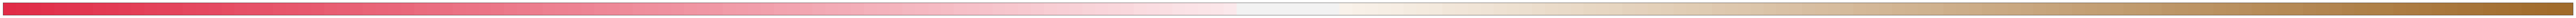

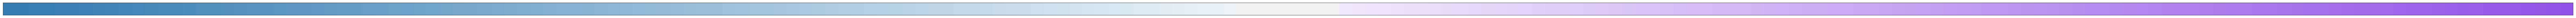

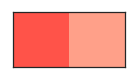

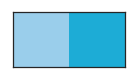

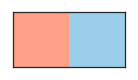

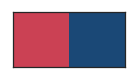

In [8]:
sns.palplot(f)
sns.palplot(m)

sns.palplot(f_2)
sns.palplot(m_2)

sns.palplot(crayons_l)
sns.palplot(crayons_d)

/home/data/nbc/nbclab-env/env-py2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


roi_names df:
['neggenderXtimeClust1', 'neggenderXtimeClust2', 'neggenderXtimeClust3', 'neggenderXtimeClust4', 'classXgenderXtimeClust1', 'classXgenderXtimeClust2', 'classXgenderXtimeClust3']


/home/data/nbc/nbclab-env/env-py2/lib/python2.7/site-packages/nilearn/plotting/find_cuts.py:285: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data[slices] *= 1.e-3
/home/data/nbc/nbclab-env/env-py2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


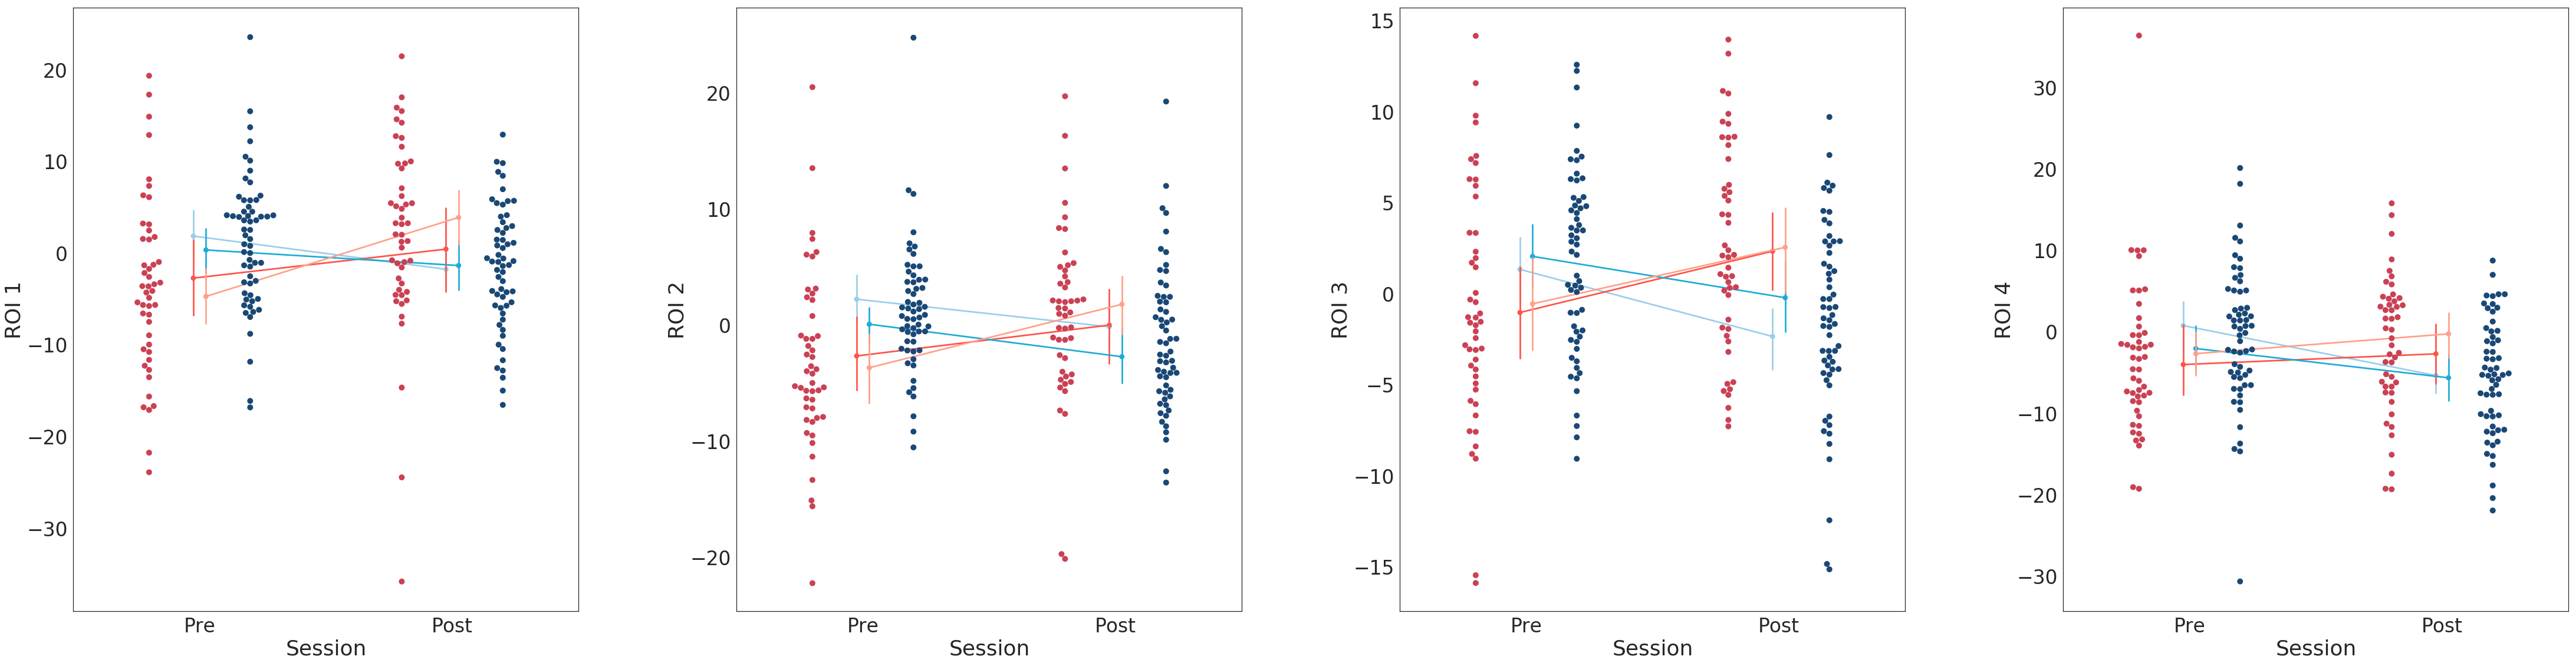

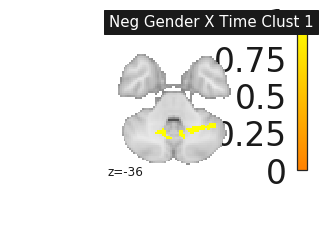

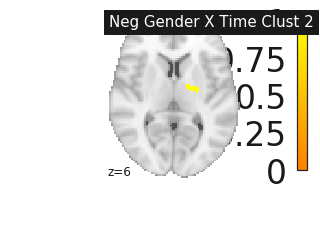

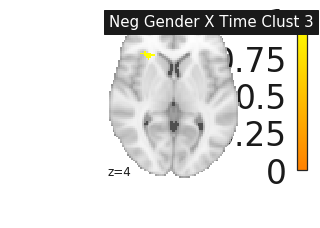

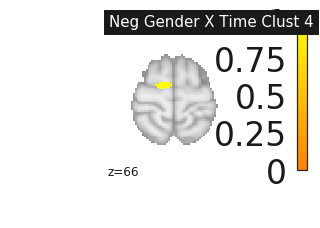

In [9]:
fig,ax = plt.subplots(ncols=4, nrows=1, figsize=(65, 20), sharex=False, sharey=False, squeeze=True)
mksz = 10
plt.tight_layout(pad=5)

#line plots
h = sns.pointplot(x='Session', y='ROI 1', hue='Class', data=twoway_clust1_df[twoway_clust1_df['Sex'] == 'M'], 
              palette=m_2, ax=ax[0], size=mksz, dodge=True)
h = sns.pointplot(x='Session', y='ROI 1', hue='Class', data=twoway_clust1_df[twoway_clust1_df['Sex'] == 'F'], 
              palette=f_2, ax=ax[0], size=mksz, dodge=True)
h.get_legend().set_visible(False)

i = sns.pointplot(x='Session', y='ROI 2', hue='Class', data=twoway_clust2_df[twoway_clust2_df['Sex'] == 'M'], 
              palette=m_2, ax=ax[1], size=mksz, dodge=True)
i = sns.pointplot(x='Session', y='ROI 2', hue='Class', data=twoway_clust2_df[twoway_clust2_df['Sex'] == 'F'], 
              palette=f_2, ax=ax[1], size=mksz, dodge=True)
i.get_legend().set_visible(False)

j = sns.pointplot(x='Session', y='ROI 3', hue='Class', data=twoway_clust3_df[twoway_clust3_df['Sex'] == 'M'], 
              palette=m_2, ax=ax[2], size=mksz, dodge=True)
j = sns.pointplot(x='Session', y='ROI 3', hue='Class', data=twoway_clust3_df[twoway_clust3_df['Sex'] == 'F'], 
              palette=f_2, ax=ax[2], size=mksz, dodge=True)
j.get_legend().set_visible(False)

k = sns.pointplot(x='Session', y='ROI 4', hue='Class', data=twoway_clust4_df[twoway_clust4_df['Sex'] == 'M'], 
              palette=m_2, ax=ax[3], size=mksz, dodge=True)
k = sns.pointplot(x='Session', y='ROI 4', hue='Class', data=twoway_clust4_df[twoway_clust4_df['Sex'] == 'F'], 
              palette=f_2, ax=ax[3], size=mksz, dodge=True)
k.get_legend().set_visible(False)


#scatter plots
h = sns.swarmplot(x='Session', y='ROI 1', hue='Sex', data=twoway_clust1_df, 
              palette=crayons_d, ax=ax[0], size=mksz, dodge=True)
h.get_legend().set_visible(False)
i = sns.swarmplot(x='Session', y='ROI 2', hue='Sex', data=twoway_clust2_df, 
              palette=crayons_d, ax=ax[1], size=mksz, dodge=True)
i.get_legend().set_visible(False)
j = sns.swarmplot(x='Session', y='ROI 3', hue='Sex', data=twoway_clust3_df, 
              palette=crayons_d, ax=ax[2], size=mksz, dodge=True)
j.get_legend().set_visible(False)
k = sns.swarmplot(x='Session', y='ROI 4', hue='Sex', data=twoway_clust4_df, 
              palette=crayons_d, ax=ax[3], size=mksz, dodge=True)
k.get_legend().set_visible(False)

fig.savefig(os.path.join(repodir, 'retr_twoway_interactions_swarmplot_updated.png'), dpi=400)

# visualize clusters for reference as axial slices
rois = []
roi_list = ['Neg Gender X Time Clust 1', 'Neg Gender X Time Clust 2', 
            'Neg Gender X Time Clust 3', 'Neg Gender X Time Clust 4', 
            'Class X Gender X Time Clust 1', 'Class X Gender X Time Clust 2', 
            'Class X Gender X Time Clust 3']#col names
roi_list_twoway = ['Neg Gender X Time Clust 1', 'Neg Gender X Time Clust 2', 
            'Neg Gender X Time Clust 3', 'Neg Gender X Time Clust 4']#col names
roi_list_threeway = ['Class X Gender X Time Clust 1', 'Class X Gender X Time Clust 2', 
            'Class X Gender X Time Clust 3']#col names
for f in retr_mask_files:
    rois.append(join(maskdir, f))
roi_names = [ri.split('/')[8].split('_')[3].split('.')[0] for ri in rois]
print "roi_names df:"
print roi_names
roi_names_twoway = roi_names[0:4]
roi_names_threeway = roi_names[4:7]

for i,roi in enumerate(rois[0:4]):
    plotting.plot_stat_map(
        roi, display_mode='z', cut_coords=1, 
        title= roi_list[i], colorbar=True, cmap = 'autumn')

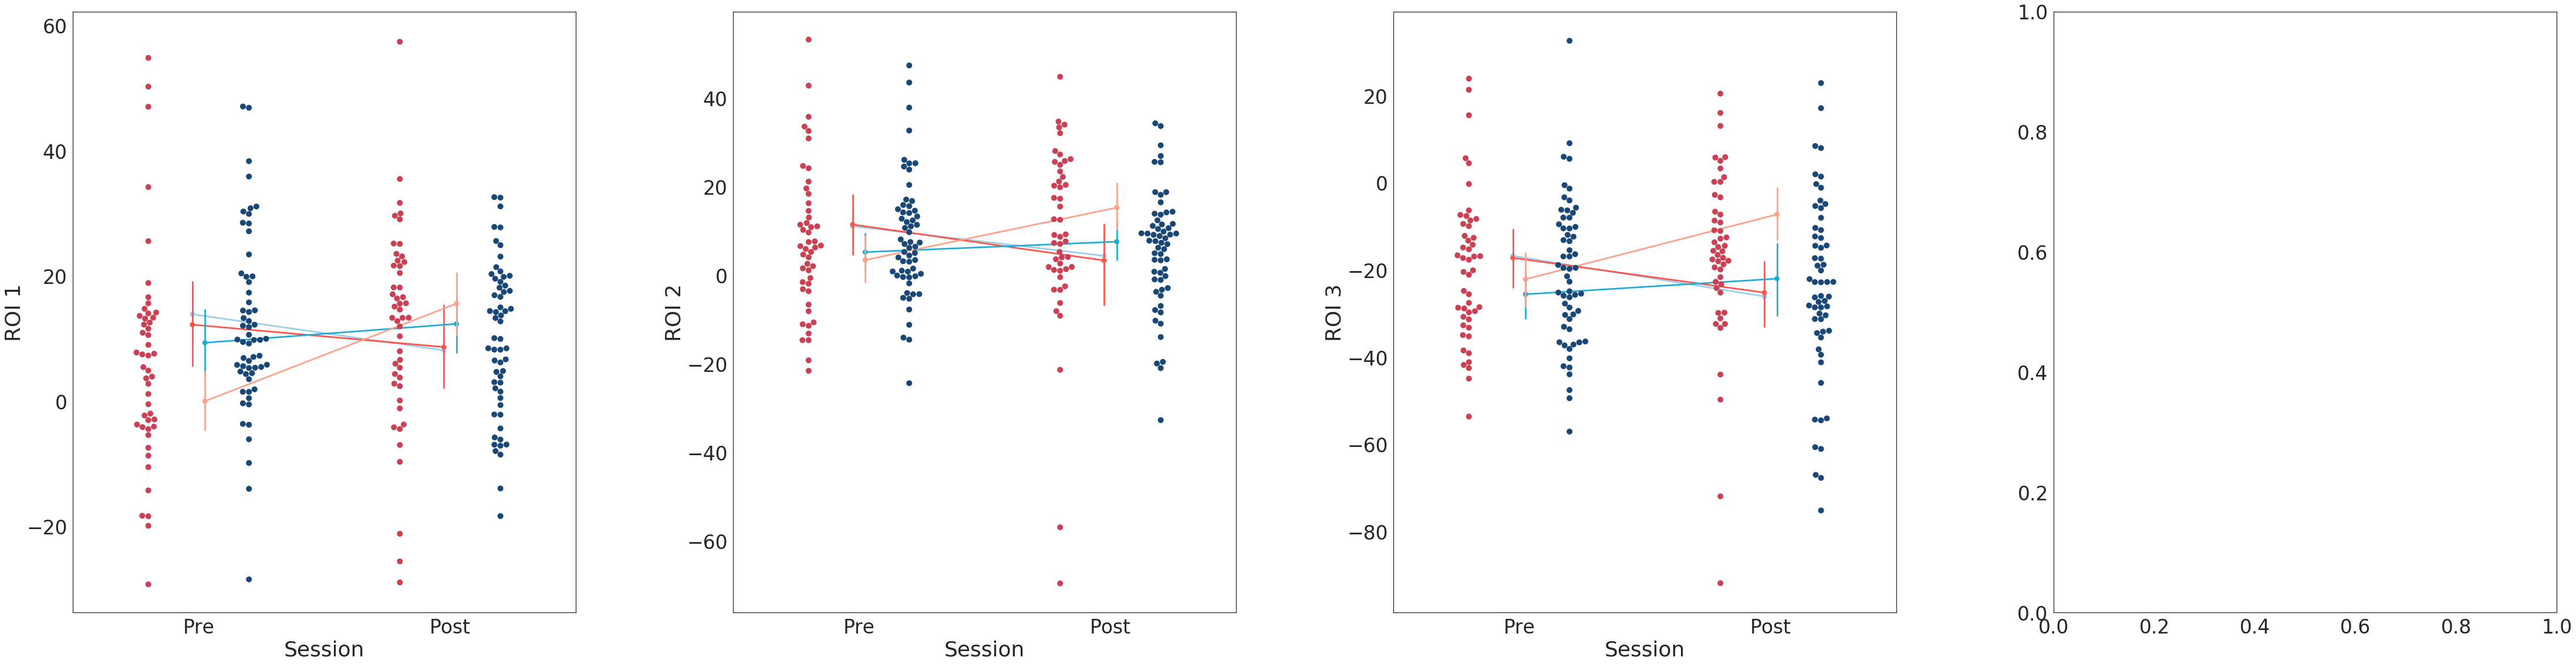

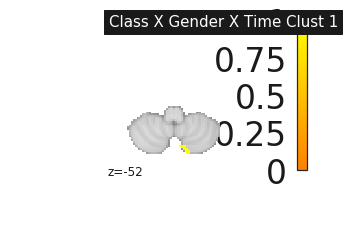

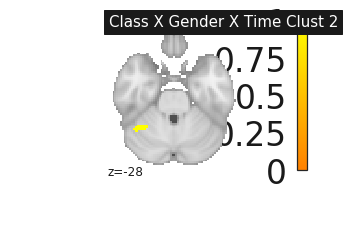

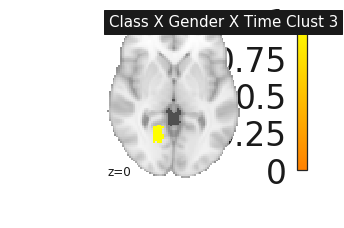

In [10]:
fig,ax = plt.subplots(ncols=4, nrows=1, figsize=(65, 20), sharex=False, sharey=False, squeeze=True)
mksz = 10
plt.tight_layout(pad=5)

#line plots
l = sns.pointplot(x='Session', y='ROI 1', hue='Class', data=threeway_clust1_df[threeway_clust1_df['Sex'] == 'M'], 
              palette=m_2, ax=ax[0], size=mksz, dodge=True)
l = sns.pointplot(x='Session', y='ROI 1', hue='Class', data=threeway_clust1_df[threeway_clust1_df['Sex'] == 'F'], 
              palette=f_2, ax=ax[0], size=mksz, dodge=True)
l.get_legend().set_visible(False)

m = sns.pointplot(x='Session', y='ROI 2', hue='Class', data=threeway_clust2_df[threeway_clust2_df['Sex'] == 'M'], 
              palette=m_2, ax=ax[1], size=mksz, dodge=True)
m = sns.pointplot(x='Session', y='ROI 2', hue='Class', data=threeway_clust2_df[threeway_clust2_df['Sex'] == 'F'], 
              palette=f_2, ax=ax[1], size=mksz, dodge=True)
m.get_legend().set_visible(False)

n = sns.pointplot(x='Session', y='ROI 3', hue='Class', data=threeway_clust3_df[threeway_clust3_df['Sex'] == 'M'], 
              palette=m_2, ax=ax[2], size=mksz, dodge=True)
n = sns.pointplot(x='Session', y='ROI 3', hue='Class', data=threeway_clust3_df[threeway_clust3_df['Sex'] == 'F'], 
              palette=f_2, ax=ax[2], size=mksz, dodge=True)
n.get_legend().set_visible(False)


#scatter plots
l = sns.swarmplot(x='Session', y='ROI 1', hue='Sex', data=threeway_clust1_df, 
              palette=crayons_d, ax=ax[0], size=mksz, dodge=True)
l.get_legend().set_visible(False)
m = sns.swarmplot(x='Session', y='ROI 2', hue='Sex', data=threeway_clust2_df, 
              palette=crayons_d, ax=ax[1], size=mksz, dodge=True)
m.get_legend().set_visible(False)
n = sns.swarmplot(x='Session', y='ROI 3', hue='Sex', data=threeway_clust3_df, 
              palette=crayons_d, ax=ax[2], size=mksz, dodge=True)
n.get_legend().set_visible(False)

fig.savefig(os.path.join(repodir, 'retr_threeway_interactions_swarmplot_updated.png'), dpi=400)

# visualize clusters for reference as axial slices
for i,roi in enumerate(rois[4:9]):
    #print roi
    plotting.plot_stat_map(
        roi, display_mode='z', cut_coords=1, 
        title= roi_list_threeway[i], colorbar=True, cmap = 'autumn')

In [11]:
## interrogate significant interactions
# get roi names
rois = []
for f in retr_mask_files:
    rois.append(join(maskdir, f))
roi_names = [ri.split('/')[8].split('_')[3].split('.')[0] for ri in rois]
print "roi_names df:"
print roi_names
roi_names_twoway = roi_names[0:4]
roi_names_threeway = roi_names[4:7]

# want new df with acc + gender, annotated by pre + post
df_wide = pd.merge(df_pre,df_post,on=['Subject'],suffixes=('_pre','_post'))
df_wide = df_wide.rename(index=str, columns={"Gender_pre": "Gender", 
                                             "Class_pre": "Class", 
                                             "Gender and Class_post": "Gender And Class"})
df_wide = df_wide.drop(['Gender_post', 'Class_post'], axis=1)

#dictionary for roi dfs
d_gender = {}
d_class = {}
d_gender_and_class = {}
roi_list = ['Neg Gender X Time Clust 1', 'Neg Gender X Time Clust 2', 
            'Neg Gender X Time Clust 3', 'Neg Gender X Time Clust 4', 
            'Class X Gender X Time Clust 1', 'Class X Gender X Time Clust 2', 
            'Class X Gender X Time Clust 3']#col names
roi_list_twoway = ['Neg Gender X Time Clust 1', 'Neg Gender X Time Clust 2', 
            'Neg Gender X Time Clust 3', 'Neg Gender X Time Clust 4']#col names
roi_list_threeway = ['Class X Gender X Time Clust 1', 'Class X Gender X Time Clust 2', 
            'Class X Gender X Time Clust 3']#col names

for i, roi in enumerate(roi_names):
    df_beta = df_wide.melt(id_vars='Gender', value_vars=['{0}_pre'.format(roi_list[i]), 
                                                         '{0}_post'.format(roi_list[i])],
                     var_name='{0}'.format(roi_list[i]))
    df_beta.replace(to_replace='{0}_pre'.format(roi_list[i]), value='Pre', inplace=True)
    df_beta.replace(to_replace='{0}_post'.format(roi_list[i]), value='Post', inplace=True)
    d_gender.update({roi: df_beta})
for i, roi in enumerate(roi_names):
    df_beta = df_wide.melt(id_vars='Class', value_vars=['{0}_pre'.format(roi_list[i]), 
                                                         '{0}_post'.format(roi_list[i])],
                     var_name='{0}'.format(roi_list[i]))
    df_beta.replace(to_replace='{0}_pre'.format(roi_list[i]), value='Pre', inplace=True)
    df_beta.replace(to_replace='{0}_post'.format(roi_list[i]), value='Post', inplace=True)
    d_class.update({roi: df_beta})

for i, roi in enumerate(roi_names_threeway):
    df_beta = df_wide.melt(id_vars='Gender And Class_post', value_vars=['{0}_pre'.format(roi_list_threeway[i]), 
                                                         '{0}_post'.format(roi_list_threeway[i])],
                     var_name='{0}'.format(roi_list_threeway[i]))
    df_beta = df_beta.rename(index=str, columns={"Gender And Class_post": "Gender And Class"})
    df_beta.replace(to_replace='{0}_pre'.format(roi_list_threeway[i]), value='Pre', inplace=True)
    df_beta.replace(to_replace='{0}_post'.format(roi_list_threeway[i]), value='Post', inplace=True)
    d_gender_and_class.update({roi: df_beta})

print d_gender[roi_names[0]].head()
print d_gender[roi_names[0]].tail()
print d_class[roi_names[0]].head()
print d_class[roi_names[0]].tail()
print d_gender_and_class[roi_names_threeway[0]].head()
print d_gender_and_class[roi_names_threeway[0]].tail()

roi_names df:
['neggenderXtimeClust1', 'neggenderXtimeClust2', 'neggenderXtimeClust3', 'neggenderXtimeClust4', 'classXgenderXtimeClust1', 'classXgenderXtimeClust2', 'classXgenderXtimeClust3']
  Gender Neg Gender X Time Clust 1      value
0      F                       Pre   1.485103
1      M                       Pre  23.554415
2      M                       Pre   3.580490
3      F                       Pre  -3.394952
4      M                       Pre  -1.468038
    Gender Neg Gender X Time Clust 1     value
209      M                      Post -2.593734
210      M                      Post -7.251320
211      F                      Post  3.155827
212      M                      Post -8.368134
213      F                      Post  1.242672
      Class Neg Gender X Time Clust 1      value
0   Lecture                       Pre   1.485103
1  Modeling                       Pre  23.554415
2   Lecture                       Pre   3.580490
3  Modeling                       Pre  -3.394952
4  Mo

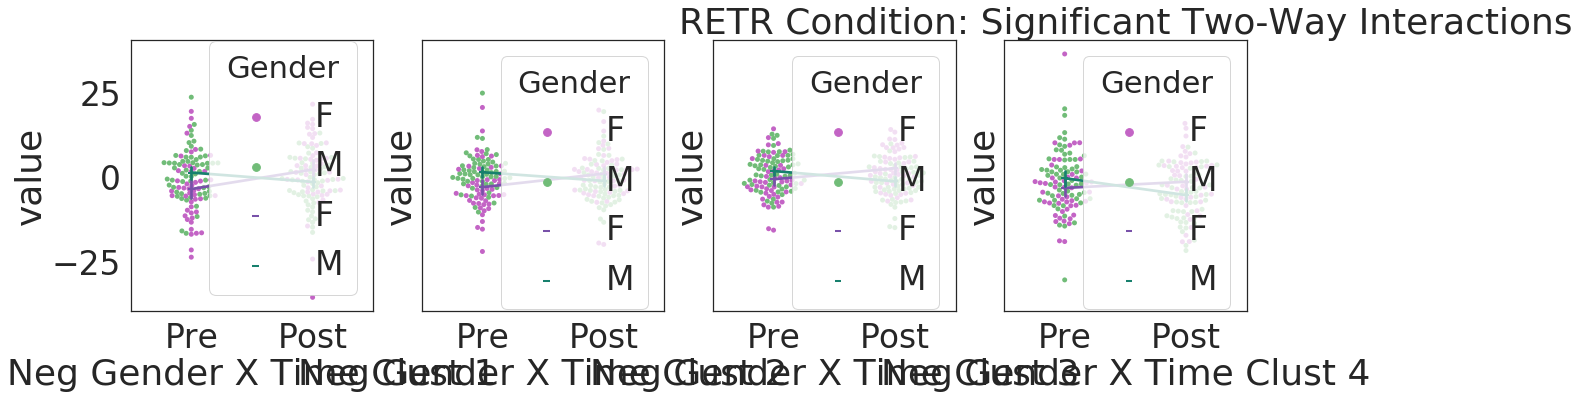

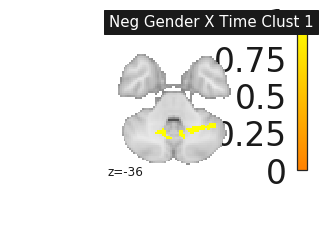

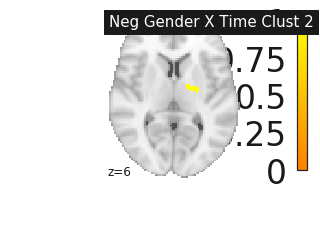

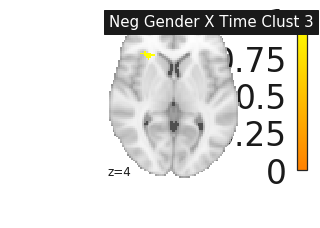

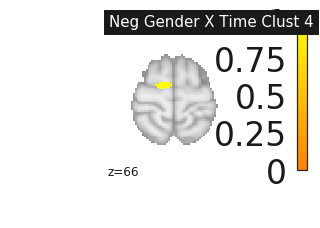

In [12]:
## Two-way interactions
# make sure roi names are not reversed so plotting index is correct for the three-way interaction plots
rois = []
for f in retr_mask_files:
    rois.append(join(maskdir, f))
roi_names = [ri.split('/')[8].split('_')[3].split('.')[0] for ri in rois]

# make swarmplots for two-way interactions
gender_crayons = sns.crayon_palette(['Fuchsia', 'Fern'])
class_crayons = sns.crayon_palette(['Copper', 'Cornflower'])
gender_and_class_crayons = sns.crayon_palette(['Fuchsia', 'Fern', 'Copper', 'Cornflower'])
gender_dark_crayons = sns.crayon_palette(['Royal Purple', 'Tropical Rain Forest'])
class_dark_crayons = sns.crayon_palette(['Raw Sienna', 'Indigo'])
gender_and_class_dark_crayons = sns.crayon_palette(['Royal Purple', 'Tropical Rain Forest', 
                                                    'Raw Sienna', 'Indigo'])

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20, 5), sharex=False, sharey=True)

plt.title('RETR Condition: Significant Two-Way Interactions')
for i, roi in enumerate(roi_list_twoway):
    sns.swarmplot(x="{0}".format(roi_list[i]), y="value", hue="Gender", data=d_gender[roi_names[i]], 
                  palette=gender_crayons, ax=ax[i], zorder=1)
    sns.pointplot(x="{0}".format(roi_list[i]), y="value", hue="Gender", data=d_gender[roi_names[i]], 
                  palette=gender_dark_crayons, ax=ax[i], zorder=100, dodge=False, 
                  markers='_')#, scale=linewidth, errwidth=linewidth+2)
fig.savefig(os.path.join(repodir, 'retr_twoway_interactions_swarmplot.png'), dpi=400)

# visualize clusters for reference as axial slices
for i,roi in enumerate(rois[0:4]):
    plotting.plot_stat_map(
        roi, display_mode='z', cut_coords=1, 
        title= roi_list[i], colorbar=True, cmap = 'autumn')

In [13]:
# I know there is a significant three-way interaction but I need to test each case (I don't yet have
# the percent signal change so the results I get with the betas may change, but at least I can set it up
# for now). Python doesn't have a repeated measures anova method (would need to calculate in R) so because
# FSL has already indicated there is a significant interaction, what I need to do (and *can* do in python)
# is run the post-hoc tests for all combinations.
# question to answer: is the shift across time in any one group different different than any other group
# so that means all combinations are (6 tests):
# Delta Mod F vs Delta Mod M
# Delta Mod F vs Delta Lect M
# Delta Mod F vs Delta Lect F
# Delta Mod M vs Delta Lect M
# Delta Mod M vs Delta Lect F
# Delta Lect F vs Delta Lect M

# Create new columnes for how each participant shifted their ROI activity over time
df_test = pd.merge(df_pre, df_post, on=['Subject'], suffixes=('_pre', '_post'))
for i, roi in enumerate(roi_list_twoway):
    df_test['{0}_delta'.format(roi)] = df_test['{0}_post'.format(roi)]-df_test['{0}_pre'.format(roi)]
for i, roi in enumerate(roi_list_threeway):
    df_test['{0}_delta'.format(roi)] = df_test['{0}_post'.format(roi)]-df_test['{0}_pre'.format(roi)]
# remove duplicate columns and rename
df_test = df_test.drop(['Condition_post', 'Gender_post', 'Class_post', 'Gender And Class_post'], axis=1)
df_test = df_test.rename(index=str, columns={"Condition_pre": "Condition", "Gender_pre": "Gender", 
                                             "Class_pre": "Class",
                                             "Gender And Class_pre": "Gender And Class"})
# make separate dfs for each group we're compairing
df_ttest_full = df_test
lectf_to_drop = ['Modeling M', 'Modeling F', 'Lecture M']
lectm_to_drop = ['Modeling M', 'Modeling F', 'Lecture F']
modf_to_drop = ['Modeling M', 'Lecture F', 'Lecture M']
modm_to_drop = ['Modeling F', 'Lecture F', 'Lecture M']
df_ttest_lectf = df_test[~df_test['Gender And Class'].isin(lectf_to_drop)]
df_ttest_lectm = df_test[~df_test['Gender And Class'].isin(lectm_to_drop)]
df_ttest_modf = df_test[~df_test['Gender And Class'].isin(modf_to_drop)]
df_ttest_modm = df_test[~df_test['Gender And Class'].isin(modm_to_drop)]
#print df_ttest_lectf['Gender And Class'].head()
#print df_ttest_lectm['Gender And Class'].head()
#print df_ttest_modf['Gender And Class'].head()
#print df_ttest_modm['Gender And Class'].head()

# run all tests
# THIS SECTOIN NEEDS TO BE MADE MORE PYTHONIC
# Delta Mod F vs Delta Mod M
# Delta Mod F vs Delta Lect M
# Delta Mod F vs Delta Lect F
# Delta Mod M vs Delta Lect M
# Delta Mod M vs Delta Lect F
# Delta Lect F vs Delta Lect M
from scipy import stats
ttest_list = ['modf_v_modm', 'modf_v_lectm', 'modf_v_lectf', 
              'modm_v_lectm', 'modm_v_lectf', 'lectf_v_lectm']

# run the three-way tests (skipp the two-way tests for now bc not needed)
# embedded dictionary with structure {roi name 1: 
#                                       {group compairsion 1: p 2, 
#                                        group compairsion 1: p 2, ...}
#                                     roi name 2: 
#                                       {group compairsion 1: p 2, 
#                                        group compairsion 1: p 2, ...}
#                                    }
p_roi = {}
p = {}
n_tests = 6
for roi in roi_list_threeway:
    p_modf_v_modm = stats.ttest_ind(df_ttest_modf['{0}_delta'.format(roi)], 
                    df_ttest_modm['{0}_delta'.format(roi)])
    p.update({ttest_list[0]: p_modf_v_modm[1]})
    p_modf_v_lectm = stats.ttest_ind(df_ttest_modf['{0}_delta'.format(roi)], 
                    df_ttest_lectm['{0}_delta'.format(roi)])
    p.update({ttest_list[1]: p_modf_v_lectm[1]})
    p_modf_v_lectf = stats.ttest_ind(df_ttest_modf['{0}_delta'.format(roi)], 
                    df_ttest_lectf['{0}_delta'.format(roi)])
    p.update({ttest_list[2]: p_modf_v_lectf[1]})
    p_modm_v_lectm = stats.ttest_ind(df_ttest_modm['{0}_delta'.format(roi)], 
                    df_ttest_lectm['{0}_delta'.format(roi)])
    p.update({ttest_list[3]: p_modm_v_lectm[1]})
    p_modm_v_lectf = stats.ttest_ind(df_ttest_modm['{0}_delta'.format(roi)], 
                    df_ttest_lectf['{0}_delta'.format(roi)])
    p.update({ttest_list[4]: p_modm_v_lectf[1]})
    p_lectf_v_lectm = stats.ttest_ind(df_ttest_lectf['{0}_delta'.format(roi)], 
                    df_ttest_lectm['{0}_delta'.format(roi)])
    p.update({ttest_list[5]: p_lectf_v_lectm[1]})
    #p = {k: v * n_tests for k, v in p.iteritems()}
    p_roi.update({roi: p})

    
# list out significant differences
for roi in roi_list_threeway:
    print 'Singificant', roi, 'p valules (Bonferroni Corrected)'
    print '_____________________________________________'
    for comparison in ttest_list:
        if p_roi[roi][comparison]*n_tests < 0.05:
            print comparison, p_roi[roi][comparison]*n_tests
    print '\n'


Singificant Class X Gender X Time Clust 1 p valules (Bonferroni Corrected)
_____________________________________________
modf_v_modm 0.001727756099736773
modf_v_lectf 0.010343178588023649


Singificant Class X Gender X Time Clust 2 p valules (Bonferroni Corrected)
_____________________________________________
modf_v_modm 0.001727756099736773
modf_v_lectf 0.010343178588023649


Singificant Class X Gender X Time Clust 3 p valules (Bonferroni Corrected)
_____________________________________________
modf_v_modm 0.001727756099736773
modf_v_lectf 0.010343178588023649




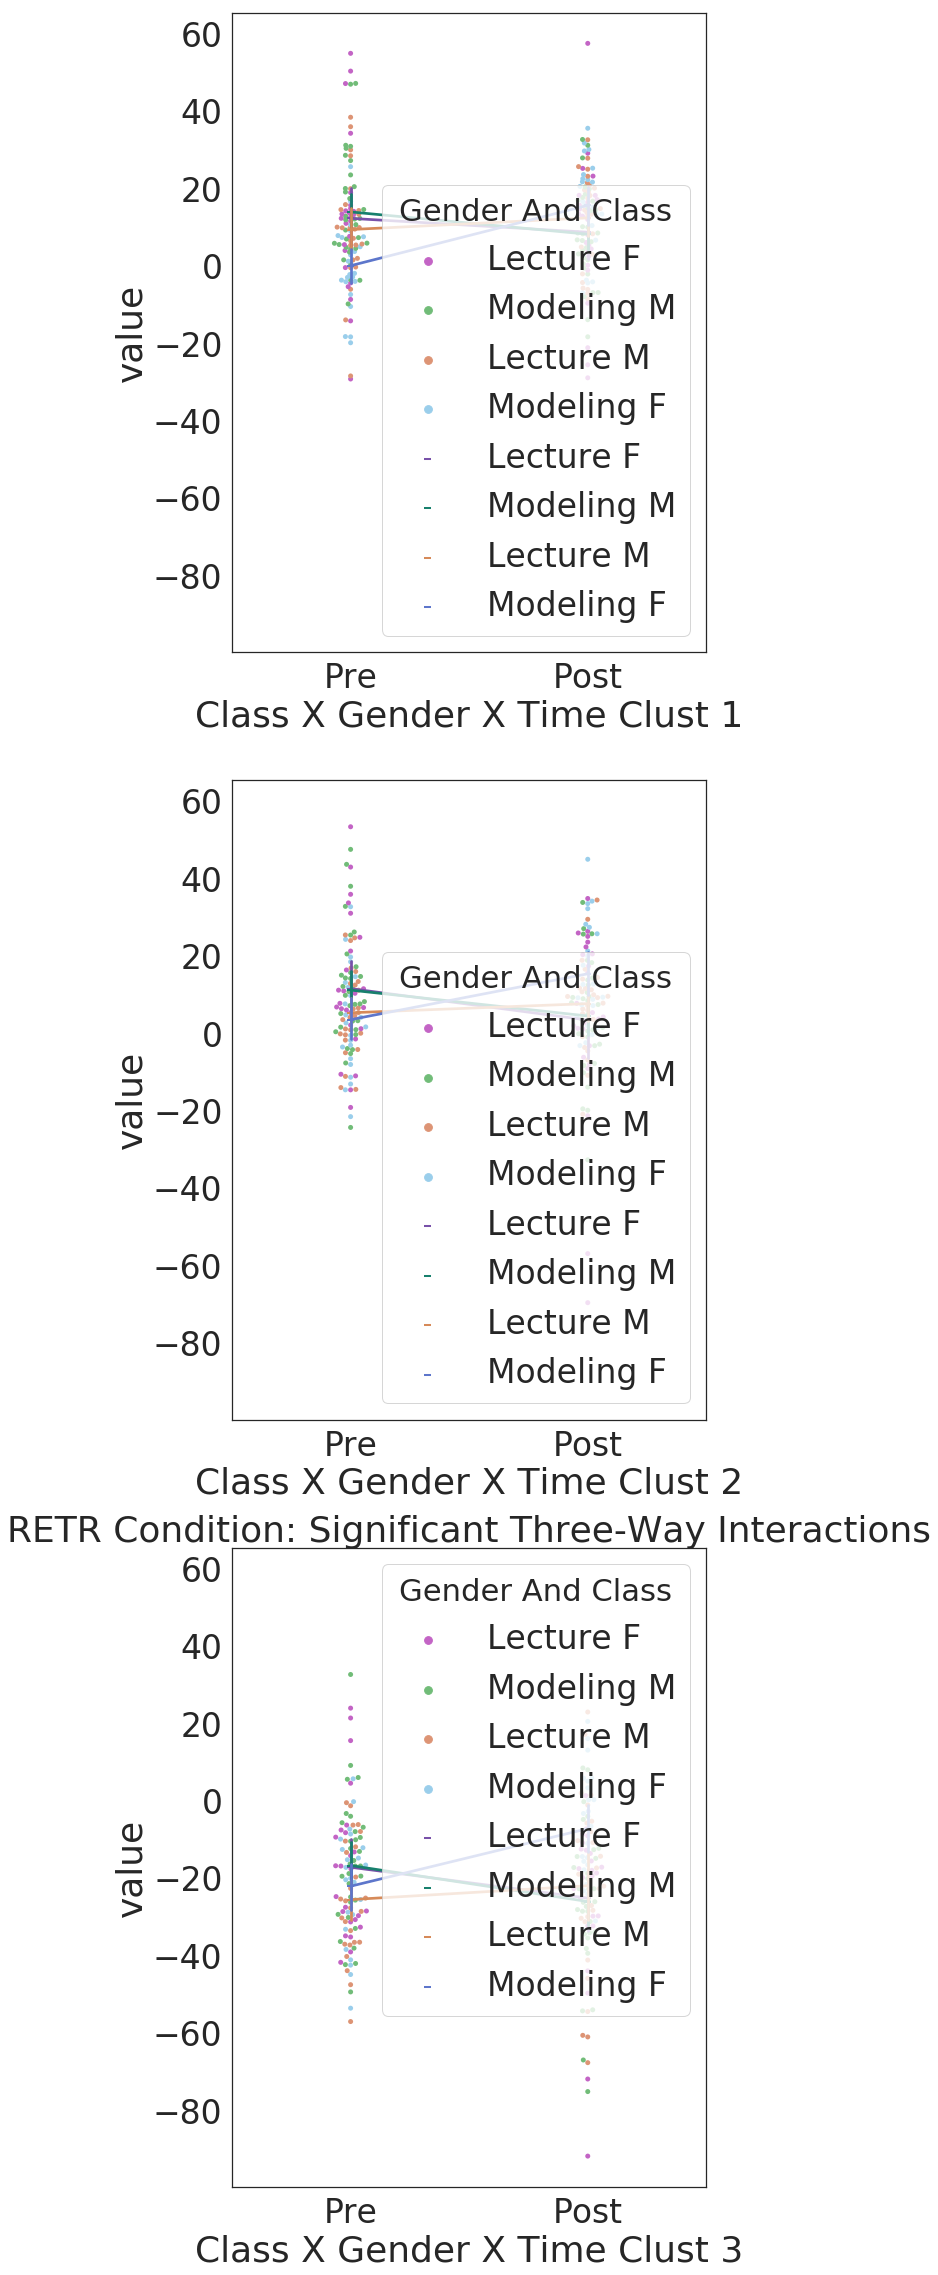

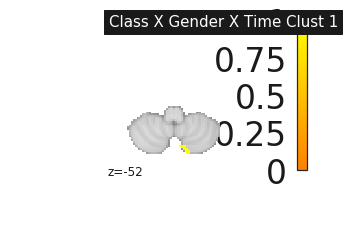

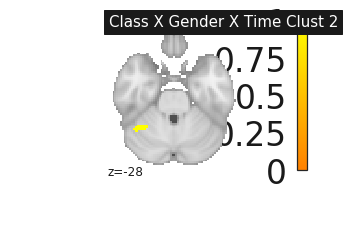

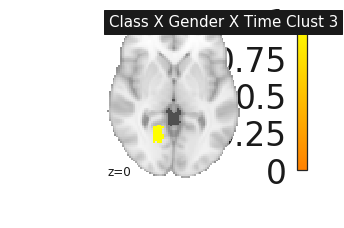

In [14]:
# Three-way interactions

# make swarmplots for three-way interactions
fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(8.5, 40), sharex=False, sharey=True)

plt.title('RETR Condition: Significant Three-Way Interactions')
for i, roi in enumerate(roi_list_threeway):
    #print d_gender_and_class[roi_names_threeway[i]].head()
    sns.swarmplot(x="{0}".format(roi_list_threeway[i]), y="value", hue="Gender And Class", 
                  data=d_gender_and_class[roi_names_threeway[i]], 
                  palette=gender_and_class_crayons, ax=ax[i], zorder=1)
    sns.pointplot(x="{0}".format(roi_list_threeway[i]), y="value", hue="Gender And Class", 
                  data=d_gender_and_class[roi_names_threeway[i]], 
                  palette=gender_and_class_dark_crayons, ax=ax[i], zorder=100, dodge=False, 
                  markers='_')#, scale=linewidth, errwidth=linewidth+2)
    
fig.savefig(os.path.join(repodir, 'retr_threeway_interactions_swarmplot.png'), dpi=400)

# visualize clusters for reference as axial slices
for i,roi in enumerate(rois[4:9]):
    #print roi
    plotting.plot_stat_map(
        roi, display_mode='z', cut_coords=1, 
        title= roi_list_threeway[i], colorbar=True, cmap = 'autumn')
